In [1]:
print('loading modules')
import numpy as np
import pandas as pd
#import rpy2
import rpy2.robjects as ro
#from rpy2.robjects import pandas2ri
#import rpy2.robjects.packages as rpackages
#ebpmf = rpackages.importr('ebpmf.alpha')
import os

print('some more modules')

from matplotlib import pyplot as plt
import seaborn as sns
import tabix
from pybedtools import BedTool
import sys

print('custom-made modules')

sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from get_isoforms import *
from prepare_counts import *
# from sNMF_plots import *
# from tqdm import tqdm
# import pingouin as pg

print('finished loading modules')

def load_ebpmf_gene(gene_id):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/RDS/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    junc_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/junctions.tab.gz'
    coords = pd_from_r_df['coords']
    junctions_bed = run_tabix_on_junc(junc_file, coords, gene_id)

    output = {'rds':pd_from_r_df, 'junctions_bed':junctions_bed}

    return output



def write_gtf(merged_isoforms, gene, strand):
    K = len(merged_isoforms)
    isoforms = [f'isoform_{str(i+1)}' for i in range(K)]
    gene_start = np.nan
    gene_end = np.nan
    chrom = merged_isoforms['isoform_1']['df'].chrom.iloc[0]

    gtf_lines = []

    gene_description = f'gene_id "{gene}"'
    
    for isoform in isoforms:
        isoform_name = gene + '.' + isoform
        df = merged_isoforms[isoform]['df']
        factors_list = merged_isoforms[isoform]['factors']
        factors_description = ':'.join(factors_list)
        iso_start = df.start.astype(int).min()
        iso_end = df.end.astype(int).max()

        gene_start = np.nanmin([gene_start, iso_start])
        gene_end = np.nanmax([gene_end, iso_end])

        iso_start = str(iso_start)
        iso_end = str(iso_end)

        isoform_description = gene_description + f'; transcript_id "{isoform_name}"; factors_id "{factors_description}"'


        isoform_row = [chrom, 's-NMF', 'transcript', iso_start, iso_end, '.', strand, '.', isoform_description]
        isoform_row = '\t'.join(isoform_row)

        gtf_lines.append(isoform_row)

        exon_count = 1
        for idx, row in df.iterrows():
            exon_start = str(int(row.start)) #str(row.start.astype(int))
            exon_end = str(int(row.end)) #str(row.end.astype(int))
            exon_name = f'exon_{str(exon_count)}'
            exon_description = isoform_description + f'; exon_id "{exon_name}"'
            exon_row = [chrom, 's-NMF', 'exon', exon_start, exon_end, '.', strand, '.', exon_description]
            exon_row = '\t'.join(exon_row)
            gtf_lines.append(exon_row)
            exon_count += 1

    gene_start = str(gene_start)
    gene_end = str(gene_end)

    gene_line = [chrom, 's-NMF', 'gene', str(int(float(gene_start))), str(int(float(gene_end))), '.', strand, '.', gene_description]
    gene_line = '\t'.join(gene_line)

    gtf_lines = [gene_line] + gtf_lines

    gene_gtf = '\n'.join(gtf_lines) + '\n'
    
    return gene_gtf 

def run_anova(EL_manova, isoform):

    res = pg.anova(dv=isoform, 
                 between='tissue_id', 
                 data=EL_manova,
                 detailed=True)

    SS_b = res.iloc[0, 1]
    SS_tot = res.iloc[1, 1]
    eta_squared = SS_b/SS_tot
    try:
        pvals = res.iloc[0, 5]
    except:
        print(res)
        return 'NA', 'NA', 'NA', 'NA'

    kw = pg.kruskal(dv=isoform, 
         between='tissue_id', 
         data=EL_manova,
         detailed=True)

    H = kw.iloc[0, 2]
    pvals_kw = kw.iloc[0, 3]

    return eta_squared, pvals, H, pvals_kw

def merge_EL(EL, merged_isoforms):
    K = EL.shape[1]
    EL = pd.DataFrame(EL)
    EL.columns = [f'factor_{str(i+1)}' for i in range(K)]
    EL_merged = pd.DataFrame()
    K_ = len(merged_isoforms)

    for i in range (K_):
        iso_name = f'isoform_{str(i+1)}'
        factors_in_isoform = merged_isoforms[iso_name]['factors']
        EL_sum = list(EL[factors_in_isoform].sum(axis=1))
        EL_merged[iso_name] = EL_sum
    
    return EL_merged

def process_gene(gene, samples, gtf_fh, correct_bias, K):#, eta_fh, pvals_fh, H_fh, kw_pvals_fh):
    rds = load_ebpmf_gene(gene)
    if 'strand' not in rds['rds'].keys():
        return None
    strand = rds['rds']['strand'][0]
    if strand == 'plus':
        strand = '+'
    else:
        strand = '-'
        
    junc_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/junctions.tab.gz'
    coords = rds['rds'][f'ebpmf_{str(K)}']['coords']
    junctions_bed = get_junctions_bed(coords, junc_file, gene)
    coords_all = list(rds['rds']['coords'])
    coords = list(rds['rds'][f'ebpmf_{str(K)}']['coords'])
    isoforms = get_isoforms(rds['rds'][f'ebpmf_{str(K)}']['train_fit']['EF_smooth'], junctions_bed, coords, coords_all, binary_fraction=0.5, 
                            correct_bias = correct_bias)
    merged_isoforms = merge_isoforms(isoforms)

    gene_gtf = write_gtf(merged_isoforms, gene, strand)
    gtf_fh.write(gene_gtf)



loading modules


During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


some more modules
custom-made modules
finished loading modules


In [2]:
print('Reading list of genes.')

samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)
print('loaded samples files')


gene = 'ENSG00000100321'
# process_gene(gene, samples, gtf_fh, correct_bias = run_lm, K=K)#, eta_fh, pvals_fh, H_fh, kw_pvals_fh)


Reading list of genes.
loaded samples files


In [3]:
rds = load_ebpmf_gene(gene)

strand = rds['rds']['strand'][0]
if strand == 'plus':
    strand = '+'
else:
    strand = '-'
    
junc_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/junctions.tab.gz'
coords = rds['rds']['ebpmf_10']['coords']
junctions_bed = get_junctions_bed(coords, junc_file, gene)
coords_all = list(rds['rds']['coords'])
coords = list(rds['rds'][f'ebpmf_10']['coords'])
isoforms = get_isoforms(rds['rds'][f'ebpmf_10']['train_fit']['EF_smooth'], junctions_bed, coords, coords_all, binary_fraction=0.5, print_gene = gene, 
                        correct_bias = False)
merged_isoforms = merge_isoforms(isoforms)

1
15
2
15
junction_4
junction_8
3
15
4
15
junction_1
junction_4
junction_7
5
15
junction_1
junction_4
junction_8
None
6
15
7
15
junction_1
junction_4
8
15
junction_1
junction_4
junction_8
9
15
junction_4
None
10
15


In [4]:
merged_isoforms

{'isoform_1': {'df':    index  chrom     start       end
  0      0  chr22  39382351  39385578,
  'factors': ['factor_1', 'factor_3']},
 'isoform_2': {'df':    chrom     start       end
  0  chr22  39374329  39374553
  1  chr22  39376052  39376197
  2  chr22  39381696  39385571,
  'factors': ['factor_2']},
 'isoform_3': {'df':    chrom     start       end
  0  chr22  39349969  39350109
  1  chr22  39374316  39374553
  2  chr22  39376052  39376197
  3  chr22  39377598  39377911,
  'factors': ['factor_4']},
 'isoform_4': {'df':    chrom     start       end
  0  chr22  39350077  39350109
  1  chr22  39374316  39374553
  2  chr22  39376052  39376197
  3  chr22  39381696  39385574,
  'factors': ['factor_5', 'factor_8']},
 'isoform_5': {'df':    index  chrom     start       end
  0      0  chr22  39384037  39385578,
  'factors': ['factor_6']},
 'isoform_6': {'df':    chrom     start       end
  0  chr22  39349942  39350109
  1  chr22  39374316  39374553
  2  chr22  39376052  39378901,
  'fac

In [5]:
39380825 - 39380615

210

In [ ]:
EF = EF[1:-1]

In [4]:
for i in range(10):
    coords_all = list(rds['rds']['coords'])
    coords = list(rds['rds'][f'ebpmf_10']['coords'])
    factor, coords = correct_factor_coords(rds['rds']['ebpmf_10']['train_fit']['EF_smooth'][1:-1,i], coords, coords_all)
    
        
    y = factor
        
    # Normalize the factor
    y = y / np.quantile(y, 0.99)
    y = np.minimum(y, 1)
    y_ = binarize_factor(y, cutoff_=0.5, binary_fraction=0.5, step_fraction=10, exon_quant=0.99, cutoff_strict=0.1, pos_window=100)
    segments_df = find_continuous_segments(coords, y_)
    print(segments_df.end - segments_df.start)

0     308
1     296
2      20
3      71
4     128
5      29
6     161
7     155
8     152
9       2
10    254
11    170
12    125
13     74
14    113
15     11
16     20
17     77
dtype: object
0     11
1    632
2    176
3    164
4    149
5    143
6      2
dtype: object
0       2
1       2
2       2
3     500
4     173
5     164
6     146
7     143
8     263
9      77
10      2
dtype: object
0    2543
1    3686
2     134
3     266
4     179
5     122
6      83
7     161
dtype: object
0    719
1    170
2    149
3    143
4    251
5    182
6    125
7     83
8    158
dtype: object
0     719
1     176
2       2
3     164
4     146
5     143
6     272
7     188
8     122
9      92
10    167
11     62
dtype: object
0    725
dtype: object
0    695
1    176
2    146
3    134
4    272
5      8
6     65
dtype: object
0    230
1    146
2    140
3    272
4    188
5    125
6     83
7    167
8     83
dtype: object
0     563
1    2552
dtype: object


In [6]:
coords[0]

'chr15:72198979'

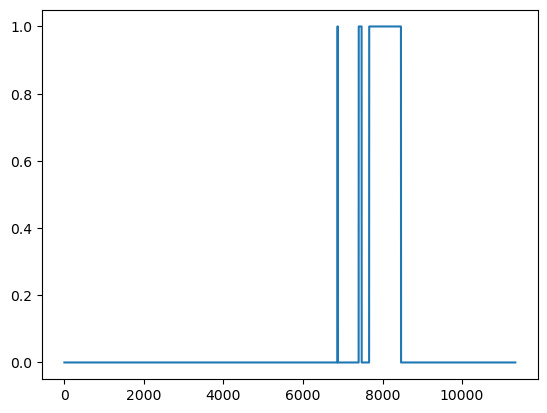

In [8]:
plt.plot(y_)

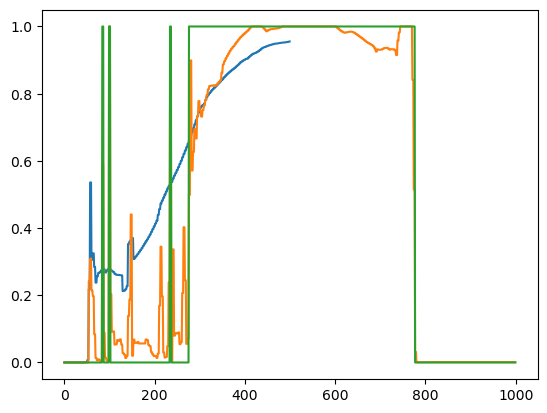

In [58]:
coords_all = list(rds['rds']['coords'])
coords = list(rds['rds'][f'ebpmf_10']['coords'])
factor, coords = correct_factor_coords(rds['rds']['ebpmf_10']['train_fit']['EF_smooth'][1:-1,1], coords, coords_all)

    
y = factor
    
# Normalize the factor
y = y / np.quantile(y, 0.99)
y = np.minimum(y, 1)
y_ = binarize_factor(y, cutoff_=0.5, binary_fraction=0.5, step_fraction=10, exon_quant=0.99, cutoff_strict=0.1, pos_window=100)

plt.plot(y[:500])

coords_all = list(rds['rds']['coords'])
coords = list(rds['rds'][f'ebpmf_10']['coords'])
factor, coords = correct_factor_coords(rds['rds']['ebpmf_10']['train_fit']['EF_smooth'][1:-1,2], coords, coords_all)

    
y = factor
    
# Normalize the factor
y = y / np.quantile(y, 0.99)
y = np.minimum(y, 1)
y_ = binarize_factor(y, cutoff_=0.5, binary_fraction=0.5, step_fraction=10, exon_quant=0.99, cutoff_strict=0.1, pos_window=100)

plt.plot(y[:1000])
plt.plot(y_[:1000])

In [59]:
get_s

NameError: name 'get_s' is not defined

In [ ]:
len(coords_all)/50

In [61]:
segments_df = find_continuous_segments(coords, y_)

In [62]:
segments_df.end - segments_df.start

0       2
1       2
2       2
3     500
4     173
5     164
6     146
7     143
8     263
9      77
10      2
dtype: object

segments_df

In [69]:
str(rds['rds']['gene'][0])

'ENSG00000067225'